<a href="https://colab.research.google.com/github/RealGoldenGeneral/mini-project-5/blob/main/cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mini Project 5 - Satellite Image Classification
### Contributors: Sepehr Mansouri & Nicky Cheng

### Setup & Loading Libraries

In [ ]:
# Imports and setup
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import random
import numpy as np
# Verify versions
print(f"TensorFlow version: {tf.__version__}")


# Import the images from form the ../data directory
# it has cloudy, desert, green area, water folders
data_dir = "../data/"
# Get class names from the directory structure as List
class_names = os.listdir(data_dir)
print(f"Classes: {class_names}")

# Setting random seed for reproducibility
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

# Plot settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Load image paths and labels
image_paths = []
labels = []
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)


# Check class distribution
from collections import Counter
class_counts = Counter(labels)
print(f"Class distribution: {class_counts}")


TensorFlow version: 2.20.0
Classes: ['cloudy', 'desert', 'green_area', 'water']
Class distribution: Counter({'cloudy': 1500, 'green_area': 1500, 'water': 1500, 'desert': 1131})


In [88]:
# Data Directory Setup & Validation

# Check if data exists locally
data_dir = "../data/"

if not os.path.exists(data_dir):
    raise FileNotFoundError(f"- Data directory not found at {os.path.abspath(data_dir)}")

if len(os.listdir(data_dir)) == 0:
    raise FileNotFoundError(f"- Data directory is empty: {os.path.abspath(data_dir)}")

print(f"- Path: {os.path.abspath(data_dir)}")

# Validate data structure
print("\n- Class folders in data directory:")
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    image_count = len([f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(f"   - {class_name}: {image_count} images")

if not class_names:
    raise FileNotFoundError(f"- No class folders found in {data_dir}")

print(f"\n- Data validation passed! Found {len(class_names)} classes")


- Path: c:\Users\Sepeh\source\repos\mini-project-5\data

- Class folders in data directory:
   - cloudy: 1500 images
   - desert: 1131 images
   - green_area: 1500 images
   - water: 1500 images

- Data validation passed! Found 4 classes


In [89]:
# Load images into TensorFlow datasets
IMG_SIZE = 250  # Original resolution (250x250)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Using 'categorical' for multi-class (4 classes)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f" Datasets loaded successfully!")
print(f"Class names: {class_names}")
print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")


Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
 Datasets loaded successfully!
Class names: ['cloudy', 'desert', 'green_area', 'water']
Training batches: 141
Validation batches: 36


### Data Exploration & Preprocessing

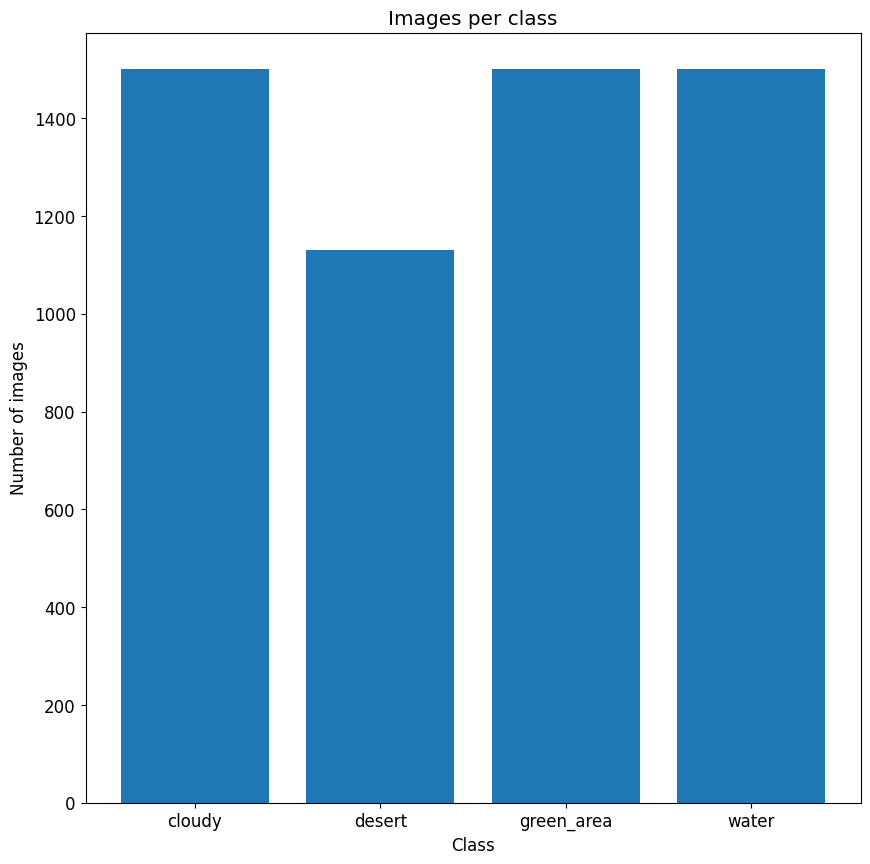

cloudy: 1500 images
desert: 1131 images
green_area: 1500 images
water: 1500 images


In [90]:
# Images per class
plt.figure(figsize=(10, 10))
plt.bar(class_names, [len(os.listdir(os.path.join(data_dir, c))) for c in class_names])
plt.title("Images per class")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

for c in class_names:
  class_dir = os.path.join(data_dir, c)
  images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)]
  print(f"{c}: {len(images)} images")

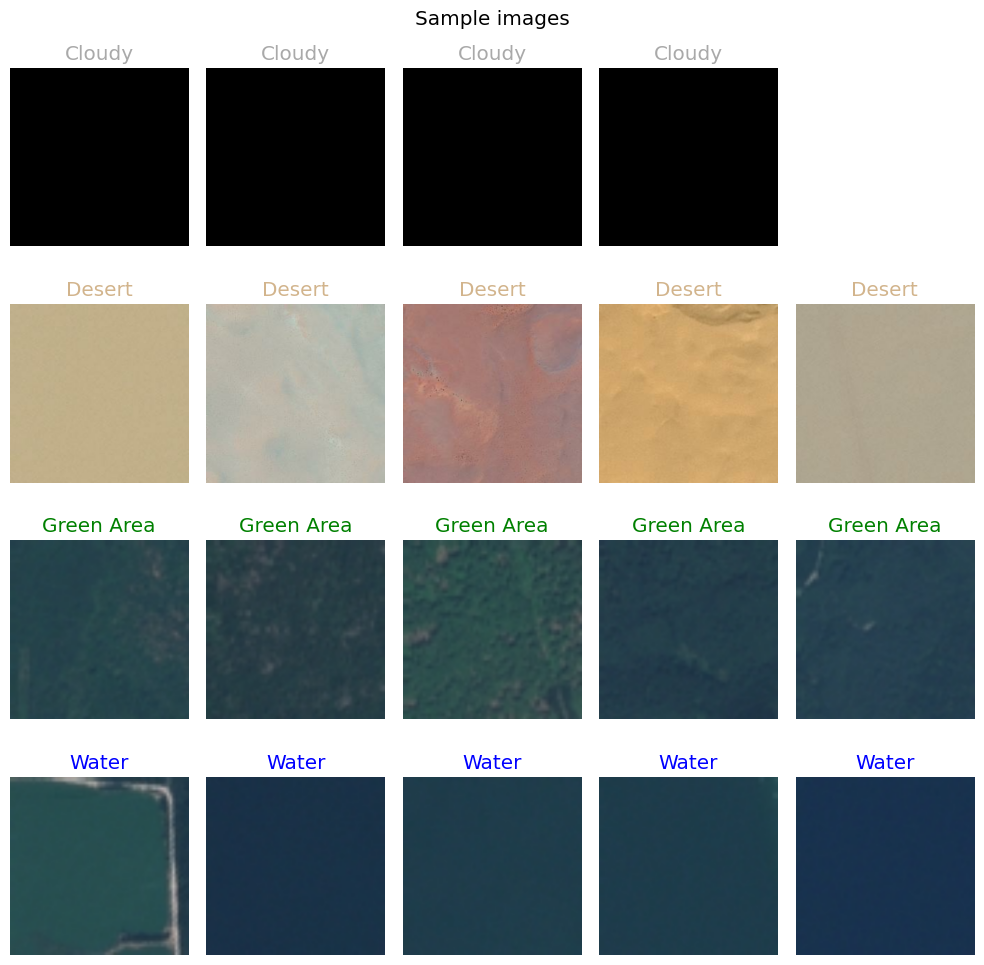

In [91]:
# Visualize sample images
plt.figure(figsize=(10, 10))

cloudy_class = class_names.index('cloudy') if 'cloudy' in class_names else 0
desert_class = class_names.index('desert') if 'desert' in class_names else 0
green_class = class_names.index('green_area') if 'green_area' in class_names else 0
water_class = class_names.index('water') if 'water' in class_names else 0

for images, labels in train_ds.take(1):
  cloudy_mask = labels[:, cloudy_class] == 1
  desert_mask = labels[:, desert_class] == 1
  green_mask = labels[:, green_class] == 1
  water_mask = labels[:, water_class] == 1

  # Show cloudy images
  cloudy_images = images[cloudy_mask]
  for i in range(min(5, len(cloudy_images))):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(cloudy_images[i].numpy())
    plt.title("Cloudy", color='darkgray')
    plt.axis('off')

  # Show desert images
  desert_images = images[desert_mask]
  for i in range(min(5, len(desert_images))):
    ax = plt.subplot(4, 5, i + 6)
    plt.imshow(desert_images[i].numpy().astype('uint8'))
    plt.title("Desert", color='tan')
    plt.axis('off')

  # Show green area images
  green_images = images[green_mask]
  for i in range(min(5, len(green_images))):
    ax = plt.subplot(4, 5, i + 11)
    plt.imshow(green_images[i].numpy().astype('uint8'))
    plt.title("Green Area", color='green')
    plt.axis('off')

  # Show water images
  water_images = images[water_mask]
  for i in range(min(5, len(water_images))):
    ax = plt.subplot(4, 5, i + 16)
    plt.imshow(water_images[i].numpy().astype('uint8'))
    plt.title("Water", color='blue')
    plt.axis('off')

plt.suptitle("Sample images")
plt.tight_layout()
plt.show()




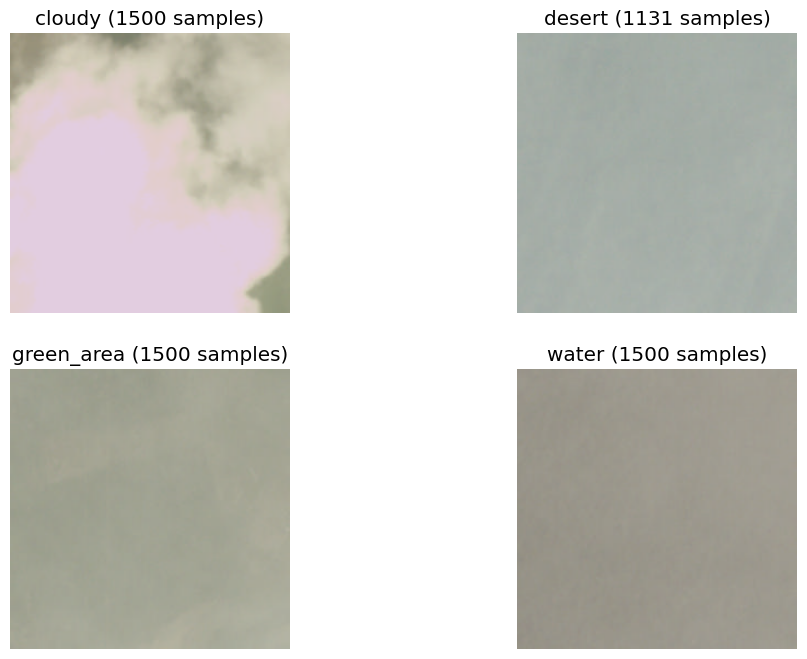

In [133]:
# Displaying images from each class
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    class_images = [img for img, label in zip(image_paths, class_names) if label == class_name]
    sample_image = random.choice(class_images)
    img = plt.imread(sample_image)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"{class_name} ({class_counts[class_name]} samples)")
    plt.axis('off')

### Baseline CNN (No Augmentation)

In [93]:
# Baseline CNN (No Augmentation)
# Custom CNN architecture (minimum 3 Conv blocks)

model_baseline = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Classification Head to Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Display model architecture
model_baseline.summary()



c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,872,836 (52.92 MB)

 Trainable params: 13,872,836 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# Compiliong the model


model_baseline.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n- Model compiled successfully!")
print("- Optimizer: Adam")
print("- Loss: Binary Crossentropy")
print("- Metrics: Accuracy")


- Model compiled successfully!
- Optimizer: Adam
- Loss: Binary Crossentropy
- Metrics: Accuracy


In [95]:
# Training the model

EPOCHS = 25
history_baseline = model_baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 187ms/step - accuracy: 0.8020 - loss: 0.3888 - val_accuracy: 0.8659 - val_loss: 0.2884
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9026 - loss: 0.2232 - val_accuracy: 0.9263 - val_loss: 0.1742
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - accuracy: 0.9274 - loss: 0.1714 - val_accuracy: 0.9281 - val_loss: 0.1701
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9265 - loss: 0.1619 - val_accuracy: 0.9236 - val_loss: 0.1809
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9216 - loss: 0.1755 - val_accuracy: 0.9290 - val_loss: 0.1766
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9243 - loss: 0.1801 - val_accuracy: 0.9307 - val_loss: 0.1856
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.9143 - loss: 0.1877 - val_accuracy: 0.9236 - val_loss: 0.1661
Epoch 8/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9250 - loss: 0

In [96]:
#  Helper function for plotting training curves (accuracy and loss)


def plot_training_curves(history, title='Model Training'):
    """Plot accuracy and loss curves for training and validation."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{title} — Accuracy', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.4, 1.05])

    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{title} — Loss', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    print(f"\n- Final Results:")
    print(f"   Train Accuracy:      {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
    print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
    print(f"   Gap (overfit check): {gap:.4f} ({gap*100:.1f}%)")
    if gap > 0.15:
        print(f"   -  Large gap — model is OVERFITTING")
    elif gap > 0.05:
        print(f"   - Moderate gap — some overfitting")
    else:
        print(f"   - Small gap — good generalization!")


def show_predictions(model, dataset, class_names, n=10):
    plt.figure(figsize=(16, 4))
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)
        for i in range(min(n, len(images))):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))

            # prediction: softmax vector -> choose top class
            pred_probs = predictions[i]
            pred_label = int(np.argmax(pred_probs))
            pred_prob = float(pred_probs[pred_label])

            # true label: handle one-hot or integer labels
            true = labels[i].numpy()
            if true.ndim > 0:
                true_label = int(np.argmax(true))
            else:
                true_label = int(true)

            color = 'green' if pred_label == true_label else 'red'
            plt.title(
                f'Pred: {class_names[pred_label]}\n({pred_prob:.2f})\nTrue: {class_names[true_label]}',
                fontsize=9, color=color, fontweight='bold'
            )
            plt.axis('off')

    plt.suptitle('Predictions (Green=Correct, Red=Wrong)', fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Helper functions loaded")

Helper functions loaded


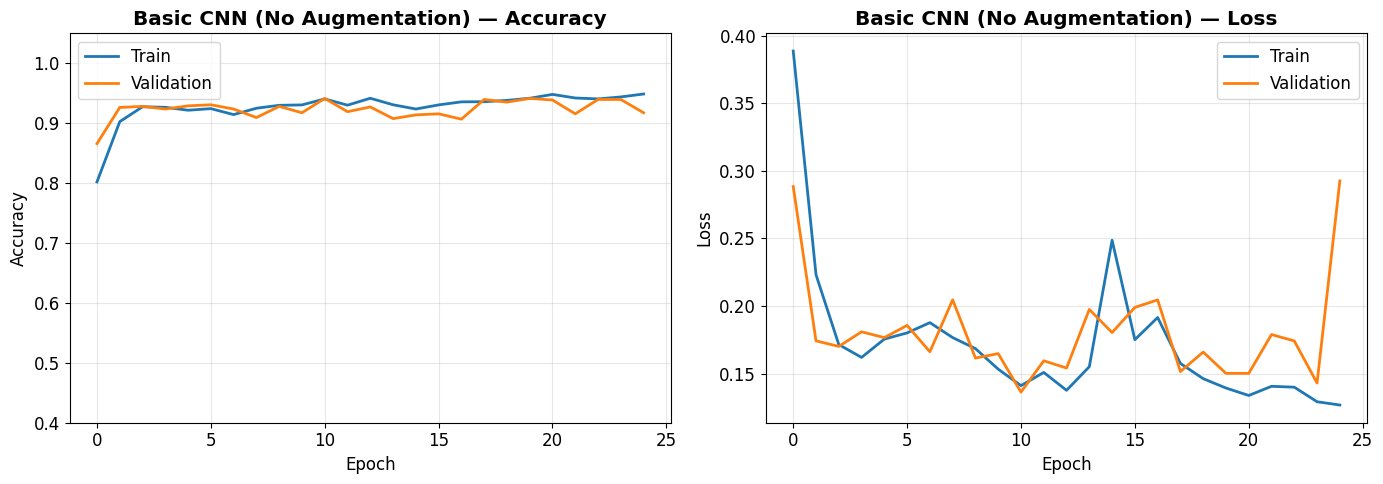


- Final Results:
   Train Accuracy:      0.9487 (94.9%)
   Validation Accuracy: 0.9174 (91.7%)
   Gap (overfit check): 0.0313 (3.1%)
   - Small gap — good generalization!


In [97]:
# Plotting the training curves
plot_training_curves(history_baseline, title='Basic CNN (No Augmentation)')

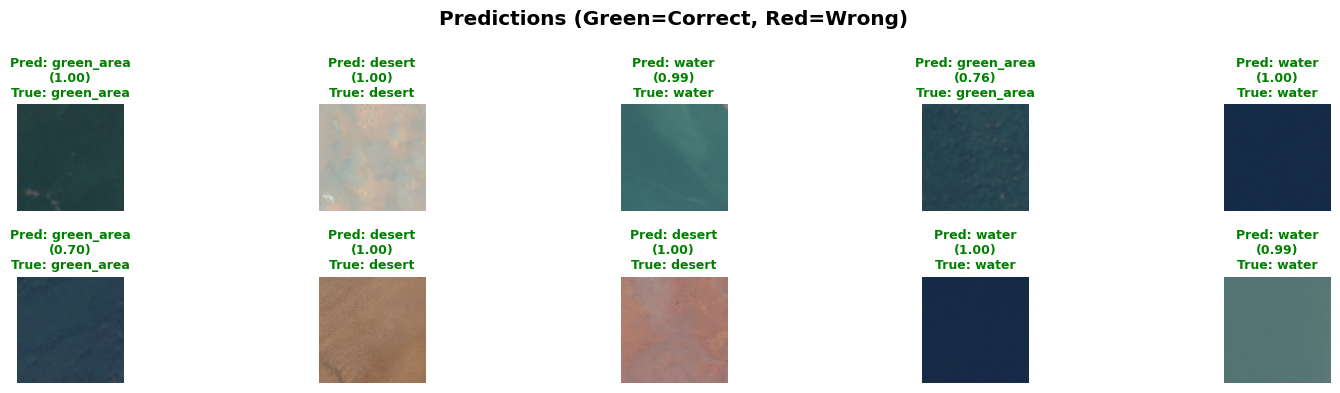

In [98]:
# Showing Predictions
show_predictions(model_baseline, val_ds, class_names)


In [99]:
# Reporting accuracy, precision, recall, and F1-score
from sklearn.metrics import classification_report, confusion_matrix
# Get true labels and predicted labels for validation set
y_true_base = []
y_pred_base = []
for images, labels in val_ds:
    preds = model_baseline.predict(images, verbose=0)
    y_true_base.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_base.extend(np.argmax(preds, axis=1))
print("\nClassification Report (Baseline Model):")
print(classification_report(y_true_base, y_pred_base, target_names=class_names))
print("Confusion Matrix:")
print(confusion_matrix(y_true_base, y_pred_base))


Classification Report (Baseline Model):
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       267
      desert       1.00      1.00      1.00       224
  green_area       0.91      0.79      0.84       318
       water       0.81      0.92      0.86       317

    accuracy                           0.92      1126
   macro avg       0.93      0.93      0.93      1126
weighted avg       0.92      0.92      0.92      1126

Confusion Matrix:
[[267   0   0   0]
 [  0 224   0   0]
 [  0   0 251  67]
 [  0   0  26 291]]


### Improved CNN (With Augmentation)

In [100]:

# Data Augmentation Layers using

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

train_ds_aug = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

for layer in data_augmentation.layers:
    print(f"- {layer.name}: {layer.__class__.__name__}")

- random_flip_5: RandomFlip
- random_rotation_5: RandomRotation
- random_zoom_5: RandomZoom
- random_contrast_5: RandomContrast


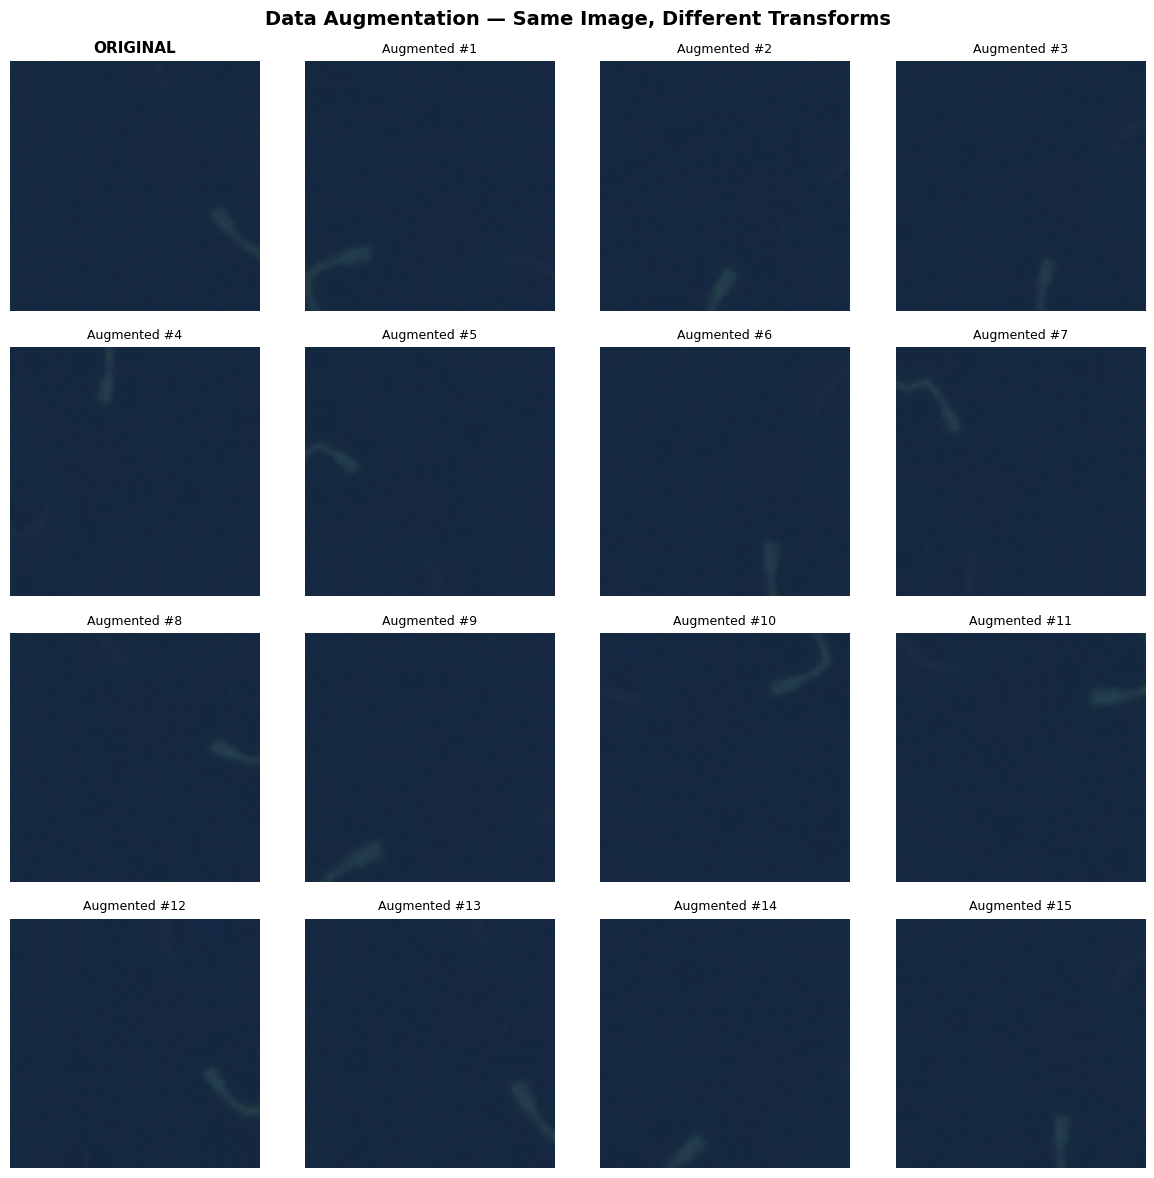

 - Each epoch, the model sees a DIFFERENT version of every training image. With augmentation both horizontal and vertical flips are possible!


In [101]:
# Visualize augmentation on a single image
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    sample_image = images[0]

    plt.subplot(4, 4, 1)
    plt.imshow(sample_image.numpy().astype('uint8'))
    plt.title('ORIGINAL', fontweight='bold', fontsize=11)
    plt.axis('off')

    for i in range(15):
        augmented = data_augmentation(tf.expand_dims(sample_image, 0), training=True)
        plt.subplot(4, 4, i + 2)
        plt.imshow(augmented[0].numpy().astype('uint8'))
        plt.title(f'Augmented #{i+1}', fontsize=9)
        plt.axis('off')

plt.suptitle('Data Augmentation — Same Image, Different Transforms', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(" - Each epoch, the model sees a DIFFERENT version of every training image. With augmentation both horizontal and vertical flips are possible!")

In [102]:
# Implement at least 3 different augmentation techniques using Keras layers


model_augmented = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model_augmented.summary()

c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 248, 248, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 122, 122, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 59, 59, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,873,732 (52.92 MB)

 Trainable params: 13,873,284 (52.92 MB)

 Non-trainable params: 448 (1.75 KB)

In [103]:
# Compile and train the augmented model

EPOCHS_AUGMENTED = 25

train_ds_aug = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
) 

model_augmented.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_augmented = model_augmented.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=EPOCHS_AUGMENTED
)

Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 70s 488ms/step - accuracy: 0.8184 - loss: 5.8249 - val_accuracy: 0.2824 - val_loss: 14.8593
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 488ms/step - accuracy: 0.8277 - loss: 1.5191 - val_accuracy: 0.2824 - val_loss: 36.5875
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 70s 493ms/step - accuracy: 0.8364 - loss: 1.0485 - val_accuracy: 0.6732 - val_loss: 2.4778
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 70s 495ms/step - accuracy: 0.8342 - loss: 0.4602 - val_accuracy: 0.8739 - val_loss: 0.2821
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 487ms/step - accuracy: 0.8861 - loss: 0.2588 - val_accuracy: 0.8579 - val_loss: 0.2854
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 68s 483ms/step - accuracy: 0.8897 - loss: 0.3013 - val_accuracy: 0.6989 - val_loss: 0.7713
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 68s 480ms/step - accuracy: 0.8921 - loss: 0.2680 - val_accuracy: 0.9156 - val_loss: 0.1992
Epoch 8/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 68s 482ms/step - accuracy: 0.9032 - loss:

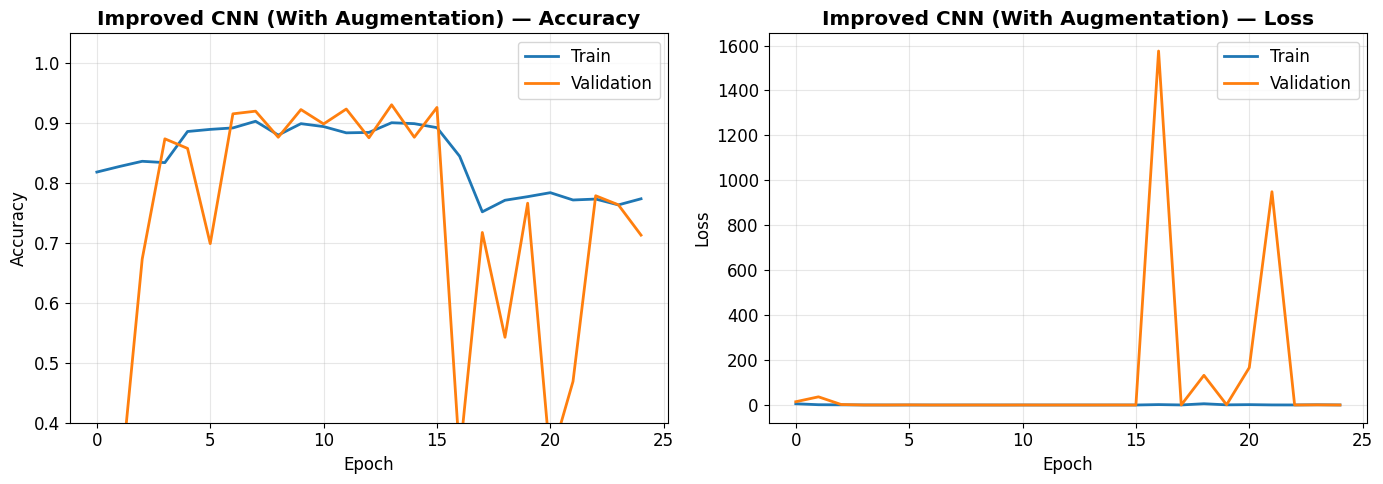


- Final Results:
   Train Accuracy:      0.7738 (77.4%)
   Validation Accuracy: 0.7131 (71.3%)
   Gap (overfit check): 0.0607 (6.1%)
   - Moderate gap — some overfitting


In [104]:
plot_training_curves(history_augmented, title='Improved CNN (With Augmentation)')

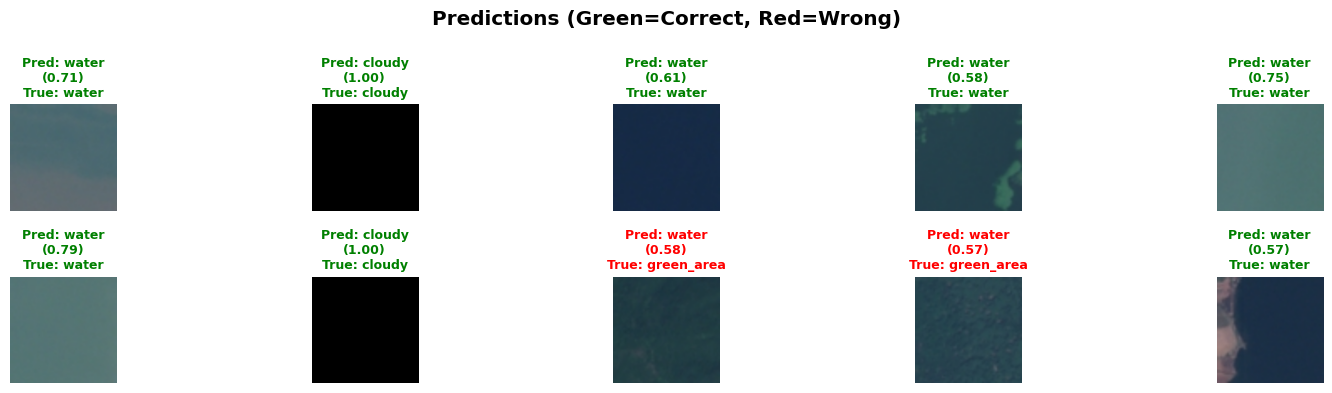

In [105]:
show_predictions(model_augmented, val_ds, class_names)

In [106]:
# Report of accuracy, precision, recall, and F1-score for the augmented model
y_true_aug = []
y_pred_aug = []
for images, labels in val_ds:
    preds = model_augmented.predict(images, verbose=0)
    y_true_aug.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_aug.extend(np.argmax(preds, axis=1))
print("\nClassification Report (Augmented Model):")
print(classification_report(y_true_aug, y_pred_aug, target_names=class_names))
print("Confusion Matrix (Augmented Model):")
print(confusion_matrix(y_true_aug, y_pred_aug))


Classification Report (Augmented Model):
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       267
      desert       1.00      0.98      0.99       224
  green_area       0.00      0.00      0.00       318
       water       0.50      1.00      0.66       317

    accuracy                           0.71      1126
   macro avg       0.62      0.74      0.66      1126
weighted avg       0.58      0.71      0.62      1126

Confusion Matrix (Augmented Model):
[[267   0   0   0]
 [  0 219   0   5]
 [  0   0   0 318]
 [  0   0   0 317]]


c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

### Model Comparison & Analysis

In [107]:
# Creating comparison table of baseline vs augmented model (showing accuracy, F1, train-val gap)
from sklearn.metrics import classification_report, f1_score
import pandas as pd

basic_train = history_baseline.history['accuracy'][-1]
basic_val = history_baseline.history['val_accuracy'][-1]
aug_train = history_augmented.history['accuracy'][-1]
aug_val = history_augmented.history['val_accuracy'][-1]
f1_base = f1_score(y_true_base, y_pred_base, average='weighted')
f1_aug  = f1_score(y_true_aug,  y_pred_aug,  average='weighted')

comparison = pd.DataFrame({
    'Model':     ['Basic CNN', 'Augmented CNN'],
    'Train Acc': [f'{basic_train:.4f}', f'{aug_train:.4f}'],
    'Val Acc':   [f'{basic_val:.4f}',   f'{aug_val:.4f}'],
    'F1 Score':  [f'{f1_base:.4f}',     f'{f1_aug:.4f}'],
    'Gap':       [f'{basic_train - basic_val:.4f}', f'{aug_train - aug_val:.4f}']
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison.to_string(index=False))
print("="*60)


MODEL COMPARISON
        Model Train Acc Val Acc F1 Score    Gap
    Basic CNN    0.9487  0.9174   0.9171 0.0313
Augmented CNN    0.7738  0.7131   0.6203 0.0607


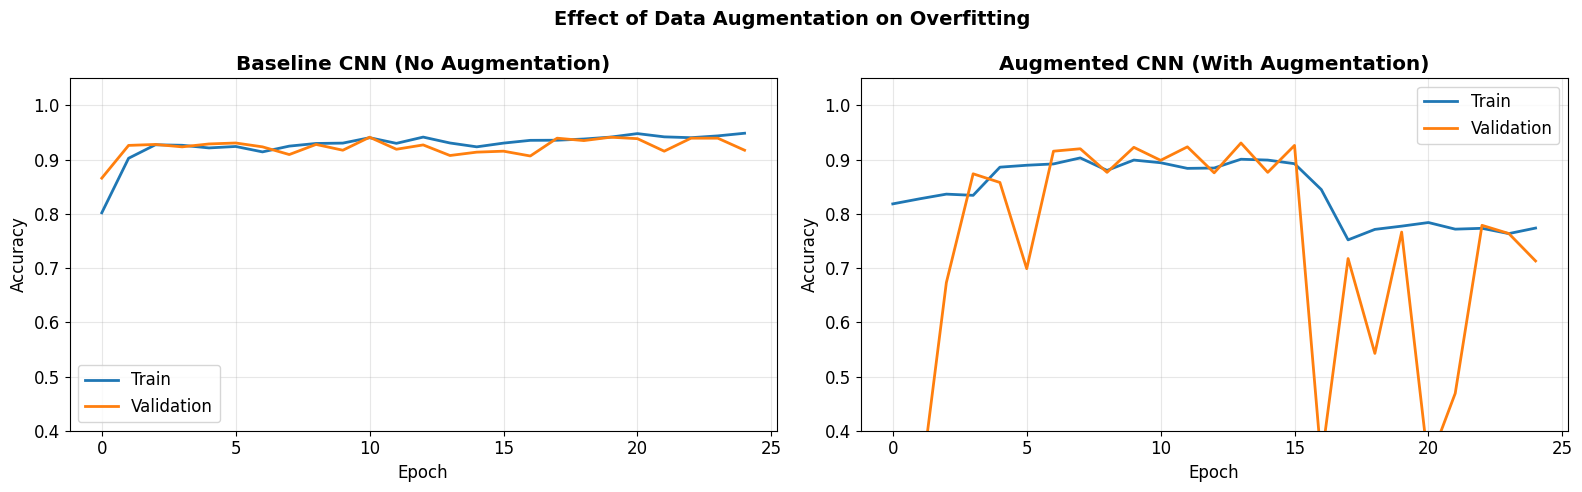

In [108]:
# Plotting train/val accuracy for both models

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history_baseline.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_baseline.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Baseline CNN (No Augmentation)', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.4, 1.05])


# Right subplot: Augmented CNN
axes[1].plot(history_augmented.history['accuracy'], label='Train', linewidth=2)
axes[1].plot(history_augmented.history['val_accuracy'], label='Validation', linewidth=2)
axes[1].set_title('Augmented CNN (With Augmentation)', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.4, 1.05])

plt.suptitle('Effect of Data Augmentation on Overfitting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Analysis

The baseline CNN significantly outperformed the augmented model, achieving 91.7% validation accuracy and a tight 3.1% train-val gap, indicating it generalized well without overfitting. The augmented CNN, by contrast, dropped to 71.3% validation accuracy with an unstable training curve. the validation accuracy fluctuates wildly between epochs, dipping as low as 40–45% at several points. 

#### Model Performance Analysis
The baseline CNN achieving 92% validation accuracy on this dataset is likely overly optimistic. Since there is no dedicated test set and the model trained for 25 epochs with no regularization, it has likely learned dataset-specific quirks rather than truly generalizing. The tight 3.1% train-val gap appears strong on paper, but satellite image datasets of this nature tend to have relatively low intra-class variation, meaning a simple CNN can effectively memorize color-based patterns (blue for water, tan for desert) without learning robust, transferable features. Performance would likely degrade significantly on truly unseen or out-of-distribution imagery.


#### Augmented Model Expectations
The augmented model's lower performance is expected and reflects a well-known tradeoff in deep learning. Augmentation intentionally makes training harder by introducing variation the model must learn to be invariant to, which means the model requires more epochs, a stronger architecture, or a carefully tuned learning rate to converge properly. The significant validation instability observed in the training curves is characteristic of a model that lacks sufficient capacity or training time to adapt to the harder augmented input distribution. Rather than concluding the augmented model is inferior, it is more accurate to characterize it as undertrained and undertuned relative to the added complexity of the augmented training regime. With proper hyperparameter tuning and additional training, the augmented model would be expected to surpass the baseline, particularly on a proper held-out test set where the baseline's memorization advantage disappears.

In [109]:
# Visualizing at least one of: feature maps, learned filters, or activation heatmaps
inp = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = inp
conv_outputs = []
conv_names = []
for layer in model_baseline.layers:
    x = layer(x)
    if isinstance(layer, layers.Conv2D):
        conv_outputs.append(x)
        conv_names.append(layer.name)
        print(f"  {layer.name}: output shape = {x.shape}")


feature_map_model = models.Model(inputs=inp, outputs=conv_outputs)

  conv2d_18: output shape = (None, 248, 248, 32)
  conv2d_19: output shape = (None, 122, 122, 64)
  conv2d_20: output shape = (None, 59, 59, 128)


Class names: ['cloudy', 'desert', 'green_area', 'water']


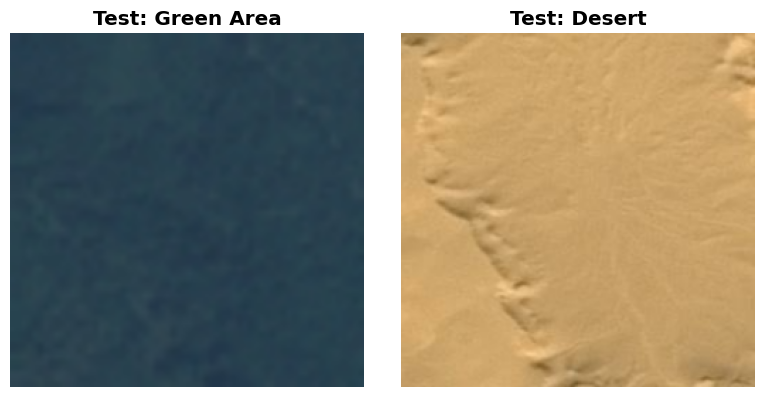

In [110]:
# Select a green_area image and a desert image for comparison
# class_names (alphabetical): ['cloudy', 'desert', 'green_area', 'water']
print("Class names:", class_names)

green_class  = class_names.index('green_area')
desert_class = class_names.index('desert')

for images, labels_batch in val_ds.take(1):
    green_idx  = None
    desert_idx = None
    for i in range(len(labels_batch)):
        label = int(np.argmax(labels_batch[i].numpy()))  # one-hot → int
        if label == green_class and green_idx is None:
            green_idx = i
        elif label == desert_class and desert_idx is None:
            desert_idx = i
        if green_idx is not None and desert_idx is not None:
            break

test_green  = images[green_idx]
test_desert = images[desert_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(test_green.numpy().astype('uint8'))
ax1.set_title('Test: Green Area', fontweight='bold')
ax1.axis('off')
ax2.imshow(test_desert.numpy().astype('uint8'))
ax2.set_title('Test: Desert', fontweight='bold')
ax2.axis('off')
plt.tight_layout()
plt.show()

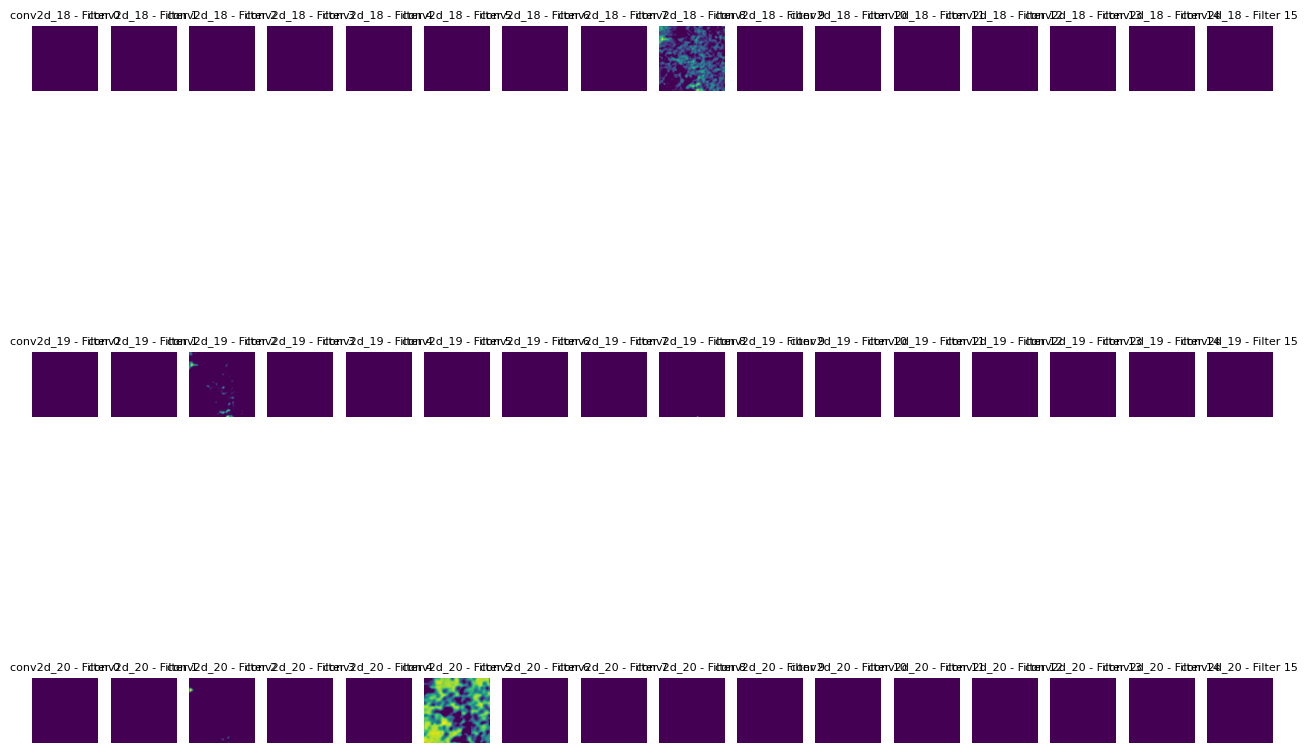

In [111]:
# Getting feature maps for image and display them

test_input = tf.expand_dims(test_green, 0)
feature_maps = feature_map_model.predict(test_input, verbose=0)

conv_names = [layer.name for layer in model_baseline.layers if isinstance(layer, layers.Conv2D)]

# displaying feature maps for each layer
plt.figure(figsize=(16, 4 * len(feature_maps)))
for layer_idx, feature_map in enumerate(feature_maps):
    num_filters = feature_map.shape[-1]
    for filter_idx in range(min(16, num_filters)):
        plt.subplot(len(feature_maps), 16, layer_idx * 16 + filter_idx + 1)
        plt.imshow(feature_map[0, :, :, filter_idx], cmap='viridis')
        plt.title(f"{conv_names[layer_idx]} - Filter {filter_idx}", fontsize=8)
        plt.axis('off')


Layer: conv2d_18, Filter shape: (3, 3, 3, 32)

Layer: conv2d_19, Filter shape: (3, 3, 32, 64)

Layer: conv2d_20, Filter shape: (3, 3, 64, 128)


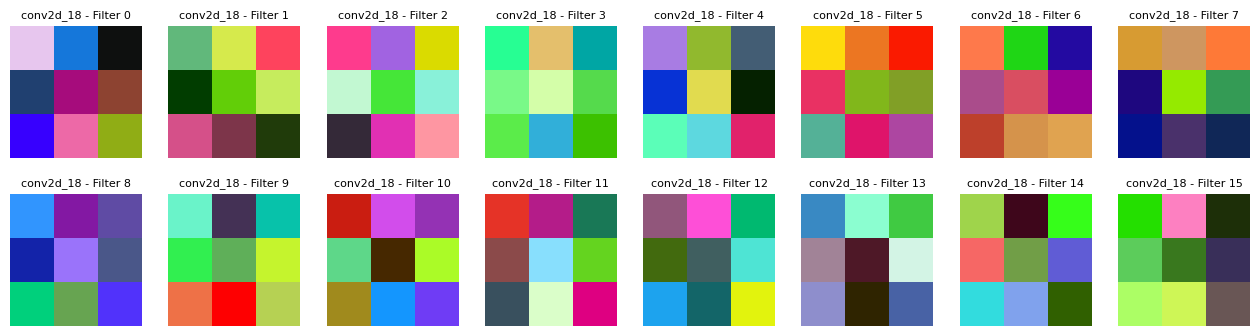

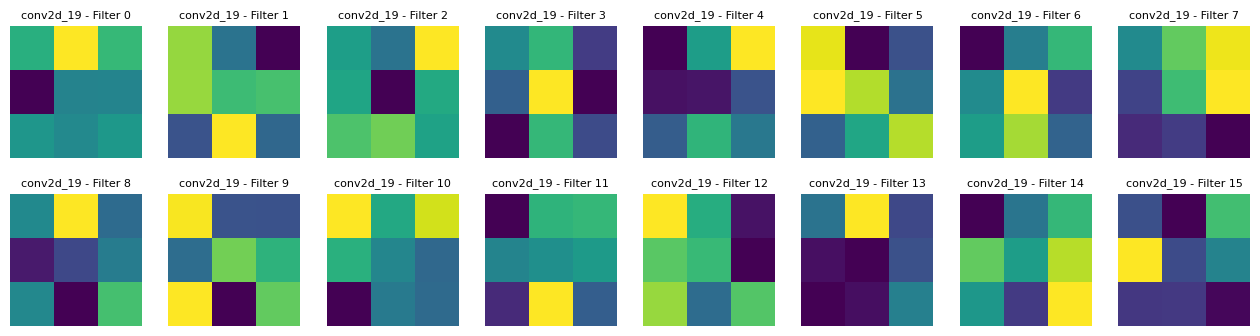

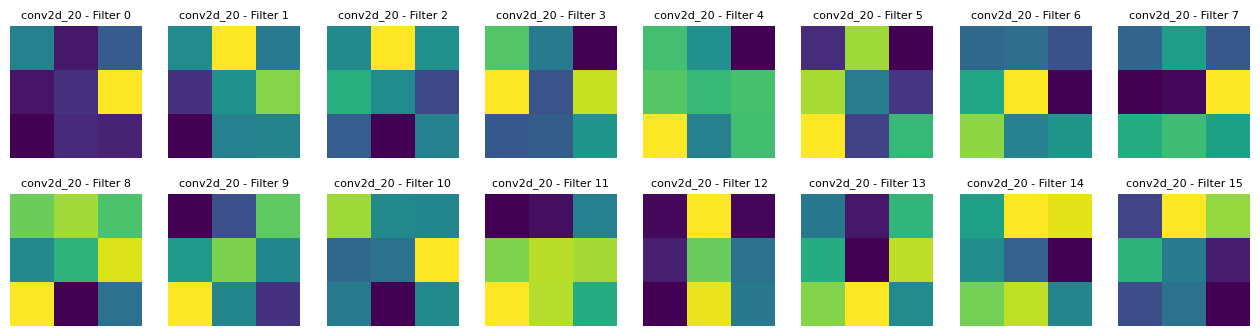

In [112]:
# Visualizing learned filters for each Conv2D layer
for layer in model_baseline.layers:
    if isinstance(layer, layers.Conv2D):
        filters, biases = layer.get_weights()
        print(f"\nLayer: {layer.name}, Filter shape: {filters.shape}")
    
        num_filters = filters.shape[-1]
        plt.figure(figsize=(16, 4))
        for filter_idx in range(min(16, num_filters)):
            f = filters[:, :, :, filter_idx]
            if f.shape[2] == 3:
                # First layer: display as RGB
                f_min, f_max = f.min(), f.max()
                f_norm = (f - f_min) / (f_max - f_min + 1e-5)
                plt.subplot(2, 8, filter_idx + 1)
                plt.imshow(f_norm)
                plt.title(f"{layer.name} - Filter {filter_idx}", fontsize=8)
                plt.axis('off')
            else:
                # Deeper layers: show mean across input channels
                f_mean = np.mean(f, axis=-1)
                f_min, f_max = f_mean.min(), f_mean.max()
                f_norm = (f_mean - f_min) / (f_max - f_min + 1e-5)
                plt.subplot(2, 8, filter_idx + 1)
                plt.imshow(f_norm, cmap='viridis')
                plt.title(f"{layer.name} - Filter {filter_idx}", fontsize=8)
                plt.axis('off')

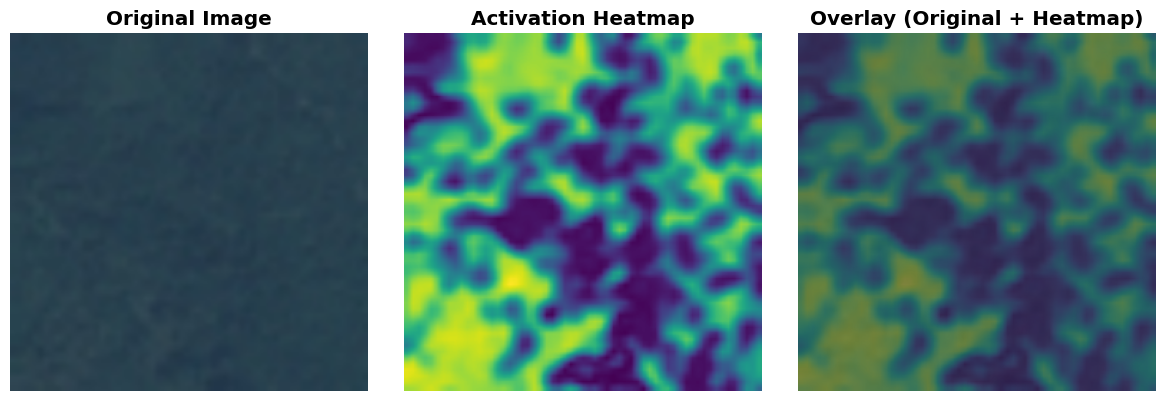

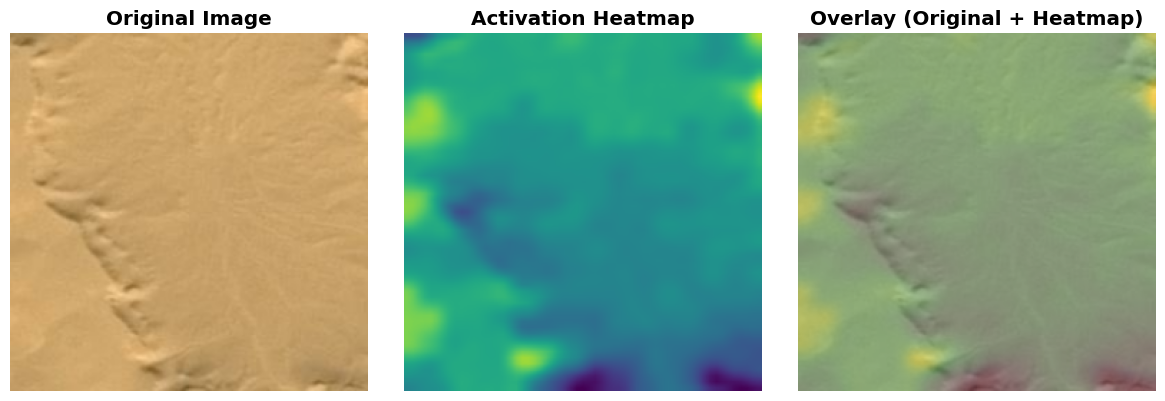

In [113]:
#  Activation heatmap

fmaps_green = feature_map_model.predict(tf.expand_dims(test_green, 0), verbose=0)
fmaps_desert = feature_map_model.predict(tf.expand_dims(test_desert, 0), verbose=0)

# Get last layer's feature maps
fmaps_last = fmaps_green[-1]  # shape: (1, H, W, 128)

heatmap = np.mean(fmaps_last[0], axis=-1)  # Average across filters
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-5)  # Normalize to [0, 1]

heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy().squeeze()
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_green.numpy().astype('uint8'))
plt.title('Original Image', fontweight='bold')
plt.axis('off') 
plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='viridis')
plt.title('Activation Heatmap', fontweight='bold')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(test_green.numpy().astype('uint8'))
plt.imshow(heatmap_resized, cmap='viridis', alpha=0.4)
plt.title('Overlay (Original + Heatmap)', fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


heatmap_desert = np.mean(fmaps_desert[-1][0], axis=-1)
heatmap_desert = (heatmap_desert - heatmap_desert.min()) / (heatmap_desert.max() - heatmap_desert.min() + 1e-5)
heatmap_desert_resized = tf.image.resize(heatmap_desert[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy().squeeze()
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_desert.numpy().astype('uint8'))
plt.title('Original Image', fontweight='bold')
plt.axis('off') 
plt.subplot(1, 3, 2)
plt.imshow(heatmap_desert_resized, cmap='viridis')
plt.title('Activation Heatmap', fontweight='bold')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(test_desert.numpy().astype('uint8'))
plt.imshow(heatmap_desert_resized, cmap='viridis', alpha=0.4)
plt.title('Overlay (Original + Heatmap)', fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


Misclassified count: 323 out of 1126 (28.7%)


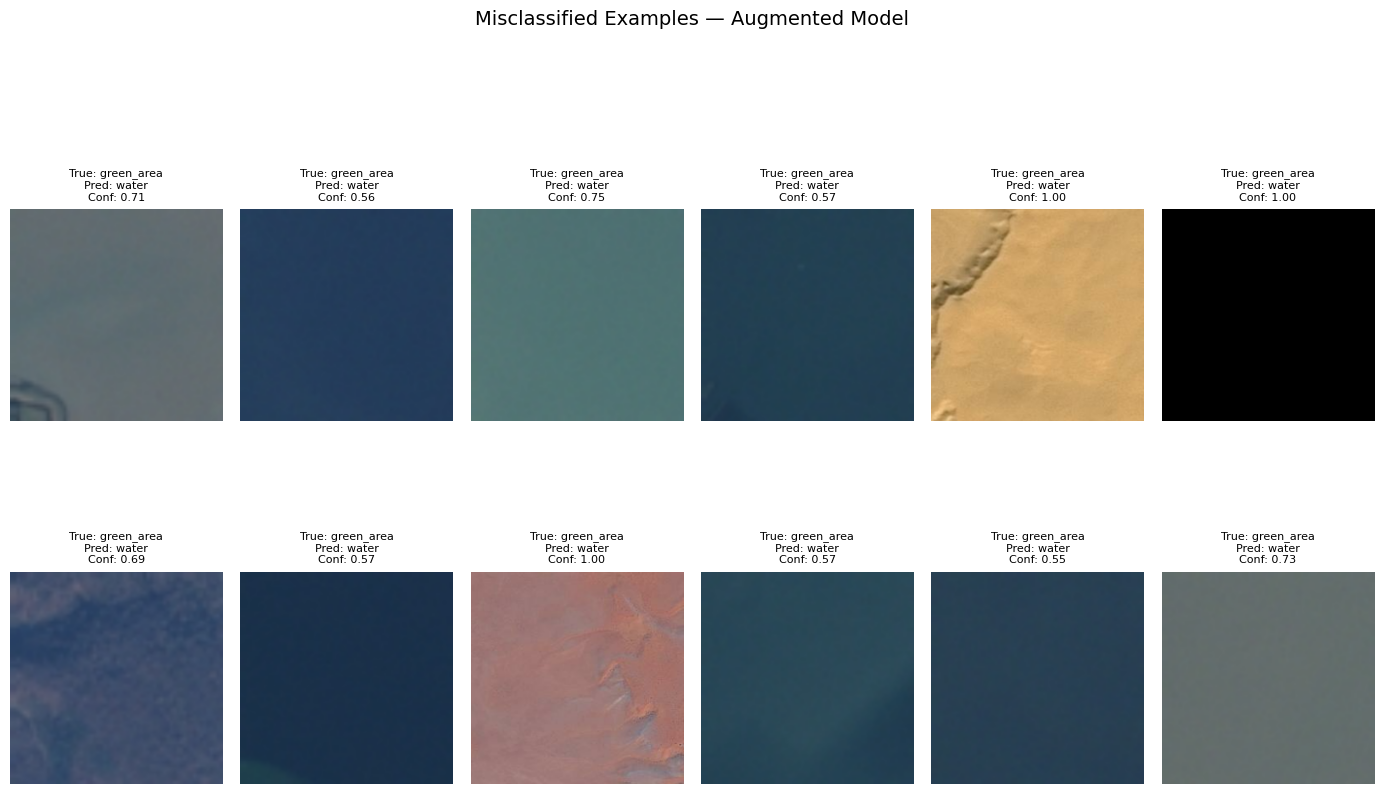

In [114]:
# Misclassified Image Analysis — Augmented Model
import math

y_true = np.array(y_true_aug)
y_pred = np.array(y_pred_aug)

# Find misclassified examples
mis_idx = np.where(y_true != y_pred)[0]
print(f"Misclassified count: {len(mis_idx)} out of {len(y_true)} ({len(mis_idx)/len(y_true)*100:.1f}%)")

# Randomly select up to 12 examples
k = min(12, len(mis_idx))
np.random.shuffle(mis_idx)
chosen = mis_idx[:k]

# Collect all validation images and their prediction confidences
all_images = []
all_probs  = []

for images, labels_batch in val_ds:
    preds = model_augmented.predict(images, verbose=0)
    all_images.extend([img.numpy().astype('uint8') for img in images])
    all_probs.extend(preds)

all_images = np.array(all_images)
all_probs  = np.array(all_probs)

# Plot misclassified examples
cols = 6
rows = math.ceil(k / cols)
plt.figure(figsize=(14, 4.5 * rows))

for i, idx in enumerate(chosen, start=1):
    img        = all_images[idx]
    true_label = y_true[idx]
    pred_label = y_pred[idx]
    conf       = float(all_probs[idx].max())

    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {conf:.2f}",
        fontsize=8
    )

plt.suptitle('Misclassified Examples — Augmented Model', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Analysis on Results:


### CNN Architecture Experiment (Bonus)

In [129]:
# Compare GAP with main model and explaination of the results

NUM_CLASSES = len(class_names)
# Comparing with the best/main model (Augmented CNN)
def build_gap_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        # Block 2
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        # Block 3
        layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        # Block 4 (extra depth vs main model)
        layers.Conv2D(256, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),

        # Key change: GAP instead of Flatten
        layers.GlobalAveragePooling2D(),

        layers.Dropout(0.4),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model


gap_model = build_gap_cnn()

In [121]:
# Compile GAP model & Show summary
gap_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

gap_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 31, 31, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 31, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,748 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [122]:
# Train GAP model
gap_history = gap_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)


Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 70s 490ms/step - accuracy: 0.9070 - loss: 0.2029 - val_accuracy: 0.7780 - val_loss: 0.4824
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 488ms/step - accuracy: 0.9090 - loss: 0.1989 - val_accuracy: 0.8730 - val_loss: 0.2458
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 489ms/step - accuracy: 0.9272 - loss: 0.1729 - val_accuracy: 0.9121 - val_loss: 0.2015
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 70s 493ms/step - accuracy: 0.9156 - loss: 0.1825 - val_accuracy: 0.9325 - val_loss: 0.1673
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 68s 485ms/step - accuracy: 0.9221 - loss: 0.1697 - val_accuracy: 0.9227 - val_loss: 0.1599
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.9223 - loss: 0.1758 - val_accuracy: 0.9014 - val_loss: 0.1881
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 68s 486ms/step - accuracy: 0.9345 - loss: 0.1517 - val_accuracy: 0.9005 - val_loss: 0.2354
Epoch 8/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 488ms/step - accuracy: 0.9272 - loss: 0

In [126]:
# Evaluate GAP model
from sklearn.metrics import classification_report, f1_score, accuracy_score

def eval_model(model, dataset):
    y_true = []
    y_pred = []

    for x_batch, y_batch in dataset:
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    return acc, f1, report


main_acc, main_f1, _ = eval_model(model_augmented, val_ds)
gap_acc, gap_f1, _   = eval_model(gap_model, val_ds)

comparison_bonus = pd.DataFrame([
    {"Model": "Main Augmented CNN", "Val Accuracy": main_acc, "Val F1 (weighted)": main_f1},
    {"Model": "GAP CNN (Bonus)",    "Val Accuracy": gap_acc,  "Val F1 (weighted)": gap_f1},
])

print(comparison_bonus.to_string(index=False))

c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

             Model  Val Accuracy  Val F1 (weighted)
Main Augmented CNN      0.713144           0.620320
   GAP CNN (Bonus)      0.940497           0.940039


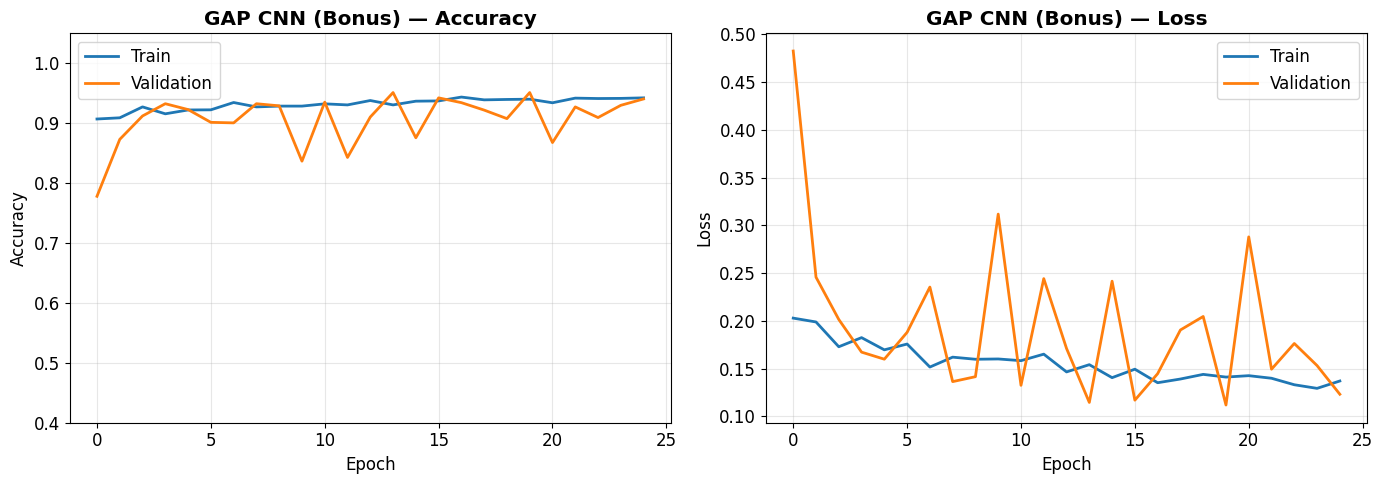


- Final Results:
   Train Accuracy:      0.9423 (94.2%)
   Validation Accuracy: 0.9405 (94.0%)
   Gap (overfit check): 0.0018 (0.2%)
   - Small gap — good generalization!


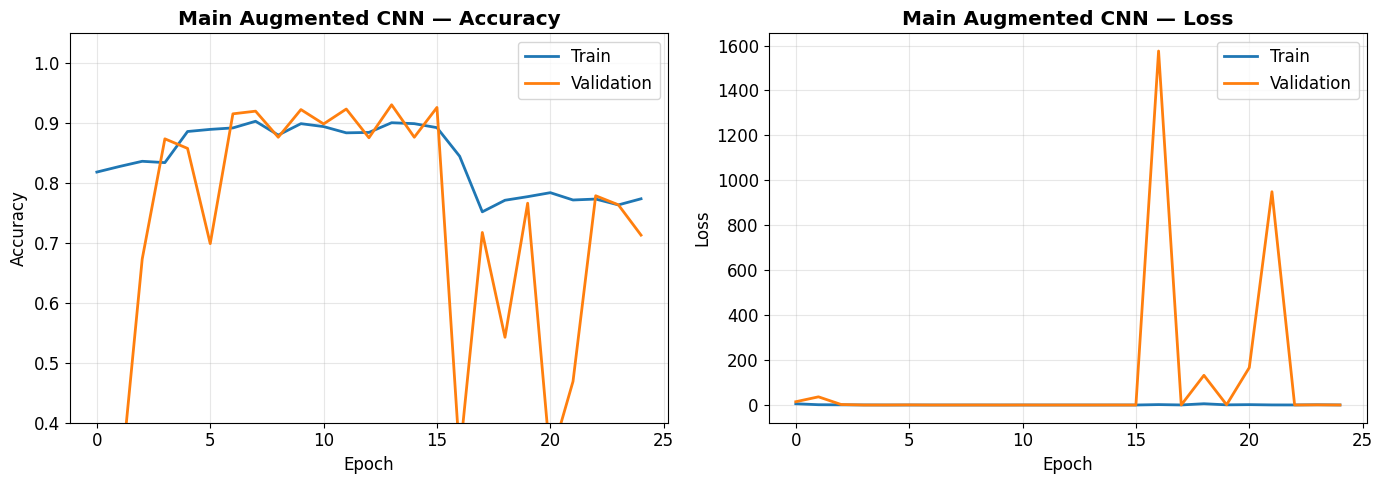


- Final Results:
   Train Accuracy:      0.7738 (77.4%)
   Validation Accuracy: 0.7131 (71.3%)
   Gap (overfit check): 0.0607 (6.1%)
   - Moderate gap — some overfitting

Comparison of Main Augmented CNN vs Bonus GAP CNN:
Main Augmented CNN - Val Accuracy: 0.7131, Val F1: 0.6203
GAP CNN (Bonus)   - Val Accuracy: 0.9405, Val F1: 0.9400


In [128]:
plot_training_curves(gap_history, title='GAP CNN (Bonus)')
plot_training_curves(history_augmented, title='Main Augmented CNN')

# Compare it against the model_augmented and discuss the results
print("\nComparison of Main Augmented CNN vs Bonus GAP CNN:")
print(f"Main Augmented CNN - Val Accuracy: {main_acc:.4f}, Val F1: {main_f1:.4f}")
print(f"GAP CNN (Bonus)   - Val Accuracy: {gap_acc:.4f}, Val F1: {gap_f1:.4f}") 



#### Bonus GAP Analysis

The GAP CNN differs from the main augmented model in four ways: an extra fourth Conv block with 256 filters, same-padding on all Conv layers, GlobalAveragePooling2D replacing Flatten, and two Dropout layers in the classification head. The most significant change is swapping Flatten for GlobalAveragePooling2D. Instead of unrolling all spatial activations into a massive vector (which caused the baseline to have over 13 million parameters), GAP averages each feature map into a single value, greatly reducing parameter count and acting as a natural regularizer.

##### Results
The GAP CNN achieved 94.0% validation accuracy with only a 0.2% train-val gap, compared to the augmented model's 71.3% accuracy and 6.1% gap. The F1 score jumped from 0.62 to 0.94. The training curves tell the same story: the GAP CNN converges smoothly and stays stable, while the augmented model collapses in later epochs with validation loss spiking into the thousands. This instability is likely caused by aggressive augmentation interacting poorly with BatchNormalization when there is no Dropout to compensate. Overall, the architectural changes in the GAP CNN, particularly GlobalAveragePooling2D and Dropout, had a much larger impact on performance than augmentation alone, which is a useful finding for future iterations of this project.